In [1]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.transform import resize

# Set base path to the dataset and target image size
base_path = "C:\\Users\\devar\\Downloads\\IIITM_Face_Emotion_dataset-20240908T082705Z-001\\IIITM_Face_Emotion_dataset"
target_size = (224, 224)

# Define emotion labels mapping
emotion_labels = {
    'NE': 0,  # Neutral
    'SA': 1,  # Sad
    'SM': 2,  # Smile
    'SO': 3,  # Surprise
    'SU': 4,  # Surprise with Open mouth
    'YN': 5   # Yawning
}

# Function to preprocess images for a specific orientation
def preprocess_orientation_data(orientation):
    data = []
    labels = []
    for subject_id in range(1, 108):
        if subject_id < 10:
            file_prefix = f'SUB{subject_id}'
            expression_start = 4
            expression_end = 6
            orientation_index = 6
        elif subject_id < 100:
            file_prefix = f'SUB{subject_id:02}'
            expression_start = 5
            expression_end = 7
            orientation_index = 7
        else:
            file_prefix = f'SUB{subject_id:03}'
            expression_start = 6
            expression_end = 8
            orientation_index = 8

        folder_name = f'SUB{subject_id}'
        folder_path = os.path.join(base_path, folder_name)
        if os.path.exists(folder_path):
            for file_name in os.listdir(folder_path):
                if file_name.startswith(file_prefix):
                    img_orientation = file_name[orientation_index]
                    if img_orientation == orientation:
                        expression = file_name[expression_start:expression_end]
                        file_path = os.path.join(folder_path, file_name)
                        image = imread(file_path)
                        image_resized = resize(image, target_size, anti_aliasing=True)
                        data.append(image_resized)
                        labels.append(emotion_labels[expression])
    return np.array(data), np.array(labels)

# Preprocess data for each orientation and save them in dictionaries
orientations = {'F': 'Front', 'U': 'Up', 'D': 'Down'}
orientation_data = {}

for ori_code, ori_name in orientations.items():
    print(f"Processing data for orientation: {ori_name}")
    data, labels = preprocess_orientation_data(ori_code)
    orientation_data[ori_name] = (data, labels)

print("Preprocessing complete for all orientations.")


Processing data for orientation: Front
Processing data for orientation: Up
Processing data for orientation: Down
Preprocessing complete for all orientations.


In [4]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Train and evaluate model for each orientation
results = {}

for ori_name, (data, labels) in orientation_data.items():
    print(f"\nTraining model for orientation: {ori_name}")
    
    # Reshape data and convert labels to one-hot encoding
    data = data.reshape(-1, 224, 224, 3)
    labels_one_hot = to_categorical(labels, num_classes=len(emotion_labels))
    
    # Split into 80% training and 20% testing sets
    X_train, X_test, y_train, y_test = train_test_split(data, labels_one_hot, test_size=0.2, random_state=42, stratify=labels)

    # Define the InceptionV3 model
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base model layers
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    output = Dense(len(emotion_labels), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test accuracy for {ori_name}: {test_accuracy * 100:.2f}%")

    # Generate a classification report
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    report = classification_report(y_test_classes, y_pred_classes, target_names=emotion_labels.keys())
    
    # Store results for each orientation
    results[ori_name] = {
        'test_accuracy': test_accuracy,
        'classification_report': report
    }

    print(f"\nClassification report for {ori_name}:\n{report}")

print("Training and evaluation complete for all orientations.")



Training model for orientation: Front
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 594ms/step - accuracy: 0.1947 - loss: 18.9676
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 589ms/step - accuracy: 0.3066 - loss: 2.6492
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 587ms/step - accuracy: 0.5126 - loss: 1.6326
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 591ms/step - accuracy: 0.4416 - loss: 1.9824
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 591ms/step - accuracy: 0.7147 - loss: 0.7236
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 600ms/step - accuracy: 0.6174 - loss: 1.0032
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 591ms/step - accuracy: 0.8007 - loss: 0.6166
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 590ms/step - accuracy: 0.8463 - loss: 0.4243
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 593ms/step - accuracy: 0.8501 - loss: 0.4686
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 596ms/step - accuracy: 0.8260 - loss: 0.4422
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 479ms/step - accuracy: 0.4018 - loss: 2.0393
Test accuracy fo

In [12]:
import numpy as np
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Define emotion labels (ensure these match your dataset's labels)
emotion_labels = ['NE', 'SA', 'SM', 'SO', 'SU', 'YN']

# Train and evaluate model for each orientation
results = {}

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=30,  # Random rotations
    width_shift_range=0.2,  # Horizontal shifts
    height_shift_range=0.2,  # Vertical shifts
    shear_range=0.2,  # Shearing transformations
    zoom_range=0.2,  # Zooming in and out
    horizontal_flip=True,  # Random horizontal flips
    fill_mode='nearest'  # Fill missing pixels after transformations
)

for ori_name, (data, labels) in orientation_data.items():
    print(f"\nTraining model for orientation: {ori_name}")
    
    # Reshape data and convert labels to one-hot encoding
    data = data.reshape(-1, 224, 224, 3)
    data = data.astype('float32') / 255.0  # Normalize pixel values
    labels_one_hot = to_categorical(labels, num_classes=len(emotion_labels))
    
    # Split into 80% training and 20% testing sets
    X_train, X_test, y_train, y_test = train_test_split(data, labels_one_hot, test_size=0.2, random_state=42, stratify=labels)

    # Apply data augmentation to training data
    train_datagen = datagen.flow(X_train, y_train, batch_size=32)

    # Define the InceptionV3 model
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model initially
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Use global average pooling instead of flatten for better performance
    x = Dense(128, activation='relu')(x)
    output = Dense(len(emotion_labels), activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Implement early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model with early stopping
    model.fit(train_datagen, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test accuracy for {ori_name}: {test_accuracy * 100:.2f}%")

    # Generate a classification report
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    report = classification_report(y_test_classes, y_pred_classes, target_names=emotion_labels)
    
    # Store results for each orientation
    results[ori_name] = {
        'test_accuracy': test_accuracy,
        'classification_report': report
    }

    print(f"\nClassification report for {ori_name}:\n{report}")

print("Training and evaluation complete for all orientations.")



Training model for orientation: Front
Epoch 1/20


C:\Users\devar\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.1504 - loss: 1.8171 - val_accuracy: 0.1628 - val_loss: 1.8021
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 919ms/step - accuracy: 0.1716 - loss: 1.7964 - val_accuracy: 0.1628 - val_loss: 1.8011
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 892ms/step - accuracy: 0.1491 - loss: 1.8015 - val_accuracy: 0.1628 - val_loss: 1.7997
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 939ms/step - accuracy: 0.1759 - loss: 1.7949 - val_accuracy: 0.1473 - val_loss: 1.7982
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 929ms/step - accuracy: 0.1722 - loss: 1.7987 - val_accuracy: 0.1628 - val_loss: 1.8213
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 899ms/step - accuracy: 0.1630 - loss: 1.8129 - val_accuracy: 0.1628 - val_loss: 1.8061
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 889ms/step - accuracy: 0.1488 - loss: 1.8030 - val_accuracy: 0.1705 - val_loss: 1.7976
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 909ms/step - accuracy: 0.1569 - loss: 1.7994 - val_accuracy: 0.1783 -

C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20


C:\Users\devar\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.1704 - loss: 1.8095 - val_accuracy: 0.1705 - val_loss: 1.7979
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.1321 - loss: 1.8095 - val_accuracy: 0.1628 - val_loss: 1.7970
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 976ms/step - accuracy: 0.1985 - loss: 1.7902 - val_accuracy: 0.1705 - val_loss: 1.7914
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 969ms/step - accuracy: 0.1208 - loss: 1.7991 - val_accuracy: 0.1628 - val_loss: 1.7921
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.1381 - loss: 1.7999 - val_accuracy: 0.1705 - val_loss: 1.7913
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 936ms/step - accuracy: 0.1584 - loss: 1.7968 - val_accuracy: 0.1705 - val_loss: 1.7961
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 950ms/step - accuracy: 0.1589 - loss: 1.8015 - val_accuracy: 0.2016 - val_loss: 1.7909
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 938ms/step - accuracy: 0.1633 - loss: 1.7937 - val_accuracy: 0.1705 - val_l

C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20


C:\Users\devar\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.1912 - loss: 1.8049 - val_accuracy: 0.1705 - val_loss: 1.7996
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 935ms/step - accuracy: 0.1547 - loss: 1.8008 - val_accuracy: 0.1705 - val_loss: 1.7968
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 933ms/step - accuracy: 0.1570 - loss: 1.7979 - val_accuracy: 0.1628 - val_loss: 1.7989
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 917ms/step - accuracy: 0.1681 - loss: 1.7981 - val_accuracy: 0.1628 - val_loss: 1.8026
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 936ms/step - accuracy: 0.1712 - loss: 1.7935 - val_accuracy: 0.1705 - val_loss: 1.7983
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - accuracy: 0.1597 - loss: 1.7987
Test accuracy for Down: 17.05%
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step 

Classification report for Down:
              precision    recall  f1-score   support

          NE       0.00      0.00      0.00        21
          SA       0.00      0.00      0.00        21
          SM       0.00      0.

C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [3]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Assuming emotion_labels is a list of emotion labels
emotion_labels = ['NE', 'SA', 'SM', 'SO', 'SU', 'YN']

# Model selection: MobileNetV2
model_choice = 'MobileNetV2'

# Train and evaluate model for each orientation
results = {}

for ori_name, (data, labels) in orientation_data.items():
    print(f"\nTraining model for orientation: {ori_name}")
    
    # Reshape data and convert labels to one-hot encoding
    data = data.reshape(-1, 224, 224, 3)
    labels_one_hot = to_categorical(labels, num_classes=len(emotion_labels))
    
    # Split into 80% training and 20% testing sets
    X_train, X_test, y_train, y_test = train_test_split(data, labels_one_hot, test_size=0.2, random_state=42, stratify=labels)
    
    # Print number of images in the training and testing sets
    print(f"Training images for {ori_name}: {X_train.shape[0]}, Testing images: {X_test.shape[0]}")

    # Choose base model: MobileNetV2
    if model_choice == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Unfreeze some layers of the base model
    base_model.trainable = True  # Unfreeze the entire base model
    fine_tune_at = 100  # Fine-tune from a certain layer onwards (optional)
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False  # Freeze earlier layers

    # Add custom layers on top
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add dropout layer for regularization
    output = Dense(len(emotion_labels), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model with a lower learning rate
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test accuracy for {ori_name}: {test_accuracy * 100:.2f}%")

    # Generate a classification report
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    report = classification_report(y_test_classes, y_pred_classes, target_names=emotion_labels)
    
    # Store results for each orientation
    results[ori_name] = {
        'test_accuracy': test_accuracy,
        'classification_report': report
    }

    print(f"\nClassification report for {ori_name}:\n{report}")

print("Training and evaluation complete for all orientations.")



Training model for orientation: Front
Training images for Front: 513, Testing images: 129
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 288ms/step - accuracy: 0.2584 - loss: 6.3857
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - accuracy: 0.4111 - loss: 1.3836
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.5424 - loss: 1.0821
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.5799 - loss: 0.9794
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.5786 - loss: 1.0300
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 323ms/step - accuracy: 0.5718 - loss: 1.0541
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step - accuracy: 0.5925 - loss: 1.0634
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 322ms/step - accuracy: 0.6863 - loss: 0.8244
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 345ms/step - accuracy: 0.7422 - loss: 0.8560
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 328ms/step - accuracy: 0.7489 - loss: 0.7360
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms

C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training images for Up: 513, Testing images: 129
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 291ms/step - accuracy: 0.2357 - loss: 4.8104
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step - accuracy: 0.3601 - loss: 1.4802
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.4232 - loss: 1.3610
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.4830 - loss: 1.2793
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - accuracy: 0.5530 - loss: 1.0395
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.6263 - loss: 0.9210
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.6956 - loss: 0.7228
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - accuracy: 0.6445 - loss: 0.8954
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.7171 - loss: 0.7279
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.7485 - loss: 0.6640
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.7204 - loss: 0.7679
Ep

C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Assuming emotion_labels is a list of emotion labels
emotion_labels = ['NE', 'SA', 'SM', 'SO', 'SU', 'YN']

# Model selection: MobileNetV2
model_choice = 'MobileNetV2'

# Train and evaluate model for each orientation
results = {}

for ori_name, (data, labels) in orientation_data.items():
    print(f"\nTraining model for orientation: {ori_name}")
    
    # Reshape data and convert labels to one-hot encoding
    data = data.reshape(-1, 224, 224, 3)
    labels_one_hot = to_categorical(labels, num_classes=len(emotion_labels))
    
    # Split into 80% training and 20% testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels_one_hot, test_size=0.2, random_state=42, stratify=labels)
    
    # Print number of images in the training and testing sets
    print(f"Training images for {ori_name}: {X_train.shape[0]}, Testing images: {X_test.shape[0]}")

    # Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.2
    )

    # Choose base model: MobileNetV2
    if model_choice == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Unfreeze some layers of the base model
    base_model.trainable = True
    fine_tune_at = 100
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout for regularization
    output = Dense(len(emotion_labels), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model with a lower learning rate
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f"{ori_name}_best_model.keras", save_best_only=True, monitor='val_loss', mode='min')

    # Train the model with data augmentation
    model.fit(
        datagen.flow(X_train, y_train, batch_size=32),
        epochs=30,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    # Load the best model weights
    model.load_weights(f"{ori_name}_best_model.keras")

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test accuracy for {ori_name}: {test_accuracy * 100:.2f}%")

    # Generate a classification report
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    report = classification_report(y_test_classes, y_pred_classes, target_names=emotion_labels)
    
    # Store results for each orientation
    results[ori_name] = {
        'test_accuracy': test_accuracy,
        'classification_report': report
    }

    print(f"\nClassification report for {ori_name}:\n{report}")

print("Training and evaluation complete for all orientations.")



Training model for orientation: Front
Training images for Front: 513, Testing images: 129
Epoch 1/30


C:\Users\devar\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 44s 922ms/step - accuracy: 0.2462 - loss: 1.8891 - val_accuracy: 0.2248 - val_loss: 1.8246
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 722ms/step - accuracy: 0.4879 - loss: 1.2049 - val_accuracy: 0.3333 - val_loss: 2.1039
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 716ms/step - accuracy: 0.6048 - loss: 0.9901 - val_accuracy: 0.3411 - val_loss: 2.7557
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 764ms/step - accuracy: 0.6616 - loss: 0.8377 - val_accuracy: 0.3643 - val_loss: 2.3306
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 702ms/step - accuracy: 0.7036 - loss: 0.7862 - val_accuracy: 0.3488 - val_loss: 2.9956
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 770ms/step - accuracy: 0.7001 - loss: 0.8306 - val_accuracy: 0.3566 - val_loss: 3.3495
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.1999 - loss: 1.8239
Test accuracy for Front: 22.48%
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 741ms/step

Classification report for Front:
              precision    recall  f1-score   support

    

C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training images for Up: 513, Testing images: 129
Epoch 1/30


C:\Users\devar\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 45s 902ms/step - accuracy: 0.2420 - loss: 1.9542 - val_accuracy: 0.3101 - val_loss: 1.9546
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 718ms/step - accuracy: 0.4534 - loss: 1.2877 - val_accuracy: 0.3643 - val_loss: 2.0053
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 684ms/step - accuracy: 0.5919 - loss: 1.1052 - val_accuracy: 0.3953 - val_loss: 2.0765
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 763ms/step - accuracy: 0.5782 - loss: 1.0238 - val_accuracy: 0.4729 - val_loss: 1.4715
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 788ms/step - accuracy: 0.6365 - loss: 0.8956 - val_accuracy: 0.4884 - val_loss: 1.4141
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 758ms/step - accuracy: 0.6680 - loss: 0.8374 - val_accuracy: 0.4884 - val_loss: 1.4094
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 716ms/step - accuracy: 0.6436 - loss: 0.8544 - val_accuracy: 0.4961 - val_loss: 2.0122
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 710ms/step - accuracy: 0.6878 - loss: 0.7923 - val_accuracy: 0.441

C:\Users\devar\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 46s 947ms/step - accuracy: 0.2755 - loss: 1.8374 - val_accuracy: 0.2326 - val_loss: 1.5942
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 810ms/step - accuracy: 0.4235 - loss: 1.3404 - val_accuracy: 0.3566 - val_loss: 1.5121
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 711ms/step - accuracy: 0.4470 - loss: 1.2264 - val_accuracy: 0.3721 - val_loss: 1.8135
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 749ms/step - accuracy: 0.5034 - loss: 1.1609 - val_accuracy: 0.3798 - val_loss: 1.6510
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 778ms/step - accuracy: 0.5644 - loss: 0.9778 - val_accuracy: 0.3488 - val_loss: 2.0077
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 720ms/step - accuracy: 0.6347 - loss: 0.8820 - val_accuracy: 0.3333 - val_loss: 2.3927
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 746ms/step - accuracy: 0.6828 - loss: 0.7799 - val_accuracy: 0.3023 - val_loss: 2.5817
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - accuracy: 0.3732 - loss: 1.5067
Test accuracy for Down: 35.66%
5/5 

C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Assuming emotion_labels is a list of emotion labels
emotion_labels = ['NE', 'SA', 'SM', 'SO', 'SU', 'YN']

# Model selection: MobileNetV2
model_choice = 'MobileNetV2'

# Early stopping callback with patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train and evaluate model for each orientation with cross-validation
results = {}

for ori_name, (data, labels) in orientation_data.items():
    print(f"\nTraining model for orientation: {ori_name}")
    
    # Reshape data and convert labels to one-hot encoding
    data = data.reshape(-1, 224, 224, 3)
    labels_one_hot = to_categorical(labels, num_classes=len(emotion_labels))
    
    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    orientation_accuracies = []
    orientation_reports = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(data, labels)):
        print(f"\nStarting fold {fold + 1} for orientation {ori_name}")
        
        # Split data into training and validation sets for the fold
        X_train, X_val = data[train_idx], data[val_idx]
        y_train, y_val = labels_one_hot[train_idx], labels_one_hot[val_idx]
        
        # Choose base model: MobileNetV2
        if model_choice == 'MobileNetV2':
            base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

        # Unfreeze some layers of the base model
        base_model.trainable = True
        fine_tune_at = 100
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False

        # Add custom layers on top
        x = Flatten()(base_model.output)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.5)(x)
        output = Dense(len(emotion_labels), activation='softmax')(x)
        model = Model(inputs=base_model.input, outputs=output)

        # Compile the model
        model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model with early stopping
        history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), 
                            callbacks=[early_stopping], verbose=1)

        # Evaluate the model on the validation set
        val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
        print(f"Validation accuracy for fold {fold + 1} of {ori_name}: {val_accuracy * 100:.2f}%")

        # Generate a classification report for the fold
        y_pred = model.predict(X_val)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_val_classes = np.argmax(y_val, axis=1)
        report = classification_report(y_val_classes, y_pred_classes, target_names=emotion_labels, output_dict=True)
        
        # Store accuracy and report for each fold
        orientation_accuracies.append(val_accuracy)
        orientation_reports.append(report)

    # Store results for each orientation
    avg_accuracy = np.mean(orientation_accuracies)
    results[ori_name] = {
        'avg_accuracy': avg_accuracy,
        'classification_reports': orientation_reports
    }

    print(f"\nAverage validation accuracy for {ori_name}: {avg_accuracy * 100:.2f}%")

print("Training and evaluation complete for all orientations.")



Training model for orientation: Front

Starting fold 1 for orientation Front
Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 29s 514ms/step - accuracy: 0.2531 - loss: 4.5456 - val_accuracy: 0.1938 - val_loss: 2.4427
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 390ms/step - accuracy: 0.4924 - loss: 1.2295 - val_accuracy: 0.3256 - val_loss: 2.8483
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 372ms/step - accuracy: 0.5611 - loss: 1.0902 - val_accuracy: 0.4109 - val_loss: 2.5005
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - accuracy: 0.6121 - loss: 0.9052 - val_accuracy: 0.4419 - val_loss: 3.1643
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 373ms/step - accuracy: 0.6950 - loss: 0.8846 - val_accuracy: 0.2713 - val_loss: 7.9932
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 396ms/step - accuracy: 0.6466 - loss: 1.0663 - val_accuracy: 0.2791 - val_loss: 4.7122
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 374ms/step - accuracy: 0.6686 - loss: 0.7911 - val_accuracy: 0.3798 - val_loss: 3.7054
Epoch 8/30
17/17 ━━━━━━━━

C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 449ms/step - accuracy: 0.2447 - loss: 4.7032 - val_accuracy: 0.1783 - val_loss: 2.3945
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 362ms/step - accuracy: 0.4155 - loss: 1.4271 - val_accuracy: 0.2636 - val_loss: 1.8431
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 382ms/step - accuracy: 0.5622 - loss: 1.1063 - val_accuracy: 0.3411 - val_loss: 2.0847
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 372ms/step - accuracy: 0.5701 - loss: 1.0606 - val_accuracy: 0.2713 - val_loss: 1.9781
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 373ms/step - accuracy: 0.6283 - loss: 0.9662 - val_accuracy: 0.2946 - val_loss: 2.4887
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 372ms/step - accuracy: 0.7037 - loss: 0.7918 - val_accuracy: 0.1783 - val_loss: 3.2021
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 356ms/step - accuracy: 0.6957 - loss: 0.7925 - val_accuracy: 0.2481 - val_loss: 4.1434
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 358ms/step - accuracy: 0.6464 - loss: 0.9565 - val_accuracy: 0

C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 29s 556ms/step - accuracy: 0.2493 - loss: 3.5362 - val_accuracy: 0.2031 - val_loss: 5.1829
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 360ms/step - accuracy: 0.4190 - loss: 1.4180 - val_accuracy: 0.1172 - val_loss: 5.8393
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 382ms/step - accuracy: 0.4992 - loss: 1.1621 - val_accuracy: 0.1953 - val_loss: 3.7015
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 379ms/step - accuracy: 0.6006 - loss: 0.9800 - val_accuracy: 0.3047 - val_loss: 3.9746
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 351ms/step - accuracy: 0.6320 - loss: 0.9355 - val_accuracy: 0.3203 - val_loss: 7.8642
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 364ms/step - accuracy: 0.6878 - loss: 0.8216 - val_accuracy: 0.3438 - val_loss: 7.5010
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 348ms/step - accuracy: 0.6709 - loss: 0.8643 - val_accuracy: 0.3672 - val_loss: 6.7293
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 352ms/step - accuracy: 0.7181 - loss: 0.7697 - val_accuracy: 0

C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 31s 500ms/step - accuracy: 0.2614 - loss: 4.5797 - val_accuracy: 0.1719 - val_loss: 5.1862
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 392ms/step - accuracy: 0.3762 - loss: 1.4186 - val_accuracy: 0.1719 - val_loss: 5.8667
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 380ms/step - accuracy: 0.5529 - loss: 1.1014 - val_accuracy: 0.1875 - val_loss: 5.6991
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 397ms/step - accuracy: 0.6067 - loss: 0.9262 - val_accuracy: 0.3203 - val_loss: 5.3546
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 375ms/step - accuracy: 0.6590 - loss: 0.8246 - val_accuracy: 0.2734 - val_loss: 3.8588
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 382ms/step - accuracy: 0.6711 - loss: 0.9526 - val_accuracy: 0.3984 - val_loss: 5.2776
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 387ms/step - accuracy: 0.7990 - loss: 0.6591 - val_accuracy: 0.5078 - val_loss: 4.5943
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 392ms/step - accuracy: 0.7138 - loss: 0.7301 - val_accuracy: 0

C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 508ms/step - accuracy: 0.2348 - loss: 4.5085 - val_accuracy: 0.1938 - val_loss: 3.4650
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 380ms/step - accuracy: 0.4593 - loss: 1.3735 - val_accuracy: 0.2791 - val_loss: 2.3456
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 372ms/step - accuracy: 0.4818 - loss: 1.2225 - val_accuracy: 0.2558 - val_loss: 4.4209
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 376ms/step - accuracy: 0.5701 - loss: 1.1097 - val_accuracy: 0.1628 - val_loss: 15.4395
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 380ms/step - accuracy: 0.6581 - loss: 1.0331 - val_accuracy: 0.1628 - val_loss: 16.8015
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 392ms/step - accuracy: 0.7222 - loss: 0.7393 - val_accuracy: 0.1705 - val_loss: 11.0642
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 393ms/step - accuracy: 0.7248 - loss: 0.8046 - val_accuracy: 0.3178 - val_loss: 5.1598
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 357ms/step - accuracy: 0.6695 - loss: 0.9015 - val_accuracy

C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 497ms/step - accuracy: 0.2442 - loss: 5.1984 - val_accuracy: 0.1705 - val_loss: 6.9262
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 371ms/step - accuracy: 0.4161 - loss: 1.4862 - val_accuracy: 0.3178 - val_loss: 4.1259
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 365ms/step - accuracy: 0.5296 - loss: 1.1094 - val_accuracy: 0.2481 - val_loss: 4.8704
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 375ms/step - accuracy: 0.5107 - loss: 1.1307 - val_accuracy: 0.3953 - val_loss: 3.6990
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 372ms/step - accuracy: 0.5285 - loss: 1.0873 - val_accuracy: 0.4496 - val_loss: 1.8712
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - accuracy: 0.5749 - loss: 1.1067 - val_accuracy: 0.4496 - val_loss: 1.4162
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 369ms/step - accuracy: 0.5776 - loss: 1.1615 - val_accuracy: 0.4496 - val_loss: 2.2793
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - accuracy: 0.6006 - loss: 0.9745 - val_accuracy: 

C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 29s 532ms/step - accuracy: 0.2391 - loss: 5.6254 - val_accuracy: 0.1719 - val_loss: 4.0703
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 364ms/step - accuracy: 0.3354 - loss: 1.5403 - val_accuracy: 0.2031 - val_loss: 3.5236
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 377ms/step - accuracy: 0.4472 - loss: 1.2775 - val_accuracy: 0.2344 - val_loss: 3.2266
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 381ms/step - accuracy: 0.4600 - loss: 1.1768 - val_accuracy: 0.2500 - val_loss: 3.1368
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 376ms/step - accuracy: 0.5222 - loss: 1.0453 - val_accuracy: 0.2031 - val_loss: 3.7837
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - accuracy: 0.5998 - loss: 0.9861 - val_accuracy: 0.1953 - val_loss: 3.4078
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 405ms/step - accuracy: 0.6559 - loss: 0.8368 - val_accuracy: 0.3984 - val_loss: 1.5323
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - accuracy: 0.5732 - loss: 1.0406 - val_accuracy: 0

C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 29s 528ms/step - accuracy: 0.2435 - loss: 5.3038 - val_accuracy: 0.1797 - val_loss: 3.9815
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 428ms/step - accuracy: 0.4053 - loss: 1.4178 - val_accuracy: 0.2031 - val_loss: 4.3240
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 398ms/step - accuracy: 0.4065 - loss: 1.4039 - val_accuracy: 0.2031 - val_loss: 3.8148
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 419ms/step - accuracy: 0.5054 - loss: 1.1723 - val_accuracy: 0.2266 - val_loss: 3.0808
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 395ms/step - accuracy: 0.5937 - loss: 0.9986 - val_accuracy: 0.2344 - val_loss: 2.2185
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 392ms/step - accuracy: 0.6073 - loss: 1.0191 - val_accuracy: 0.3125 - val_loss: 2.1849
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 395ms/step - accuracy: 0.6499 - loss: 0.9060 - val_accuracy: 0.4297 - val_loss: 1.8780
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 413ms/step - accuracy: 0.6531 - loss: 0.9397 - val_accuracy: 0

C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 29s 547ms/step - accuracy: 0.2587 - loss: 4.1741 - val_accuracy: 0.2031 - val_loss: 3.1893
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 391ms/step - accuracy: 0.5118 - loss: 1.2690 - val_accuracy: 0.2344 - val_loss: 3.2245
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 395ms/step - accuracy: 0.4958 - loss: 1.2108 - val_accuracy: 0.2422 - val_loss: 2.9881
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 379ms/step - accuracy: 0.5667 - loss: 1.0724 - val_accuracy: 0.3359 - val_loss: 2.4311
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 355ms/step - accuracy: 0.5562 - loss: 1.0363 - val_accuracy: 0.3047 - val_loss: 6.2501
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - accuracy: 0.5879 - loss: 0.9360 - val_accuracy: 0.3281 - val_loss: 6.0200
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 393ms/step - accuracy: 0.7167 - loss: 0.7837 - val_accuracy: 0.3281 - val_loss: 5.7146
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - accuracy: 0.7508 - loss: 0.6816 - val_accuracy: 0

C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 486ms/step - accuracy: 0.2151 - loss: 6.5677 - val_accuracy: 0.1628 - val_loss: 2.7144
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 358ms/step - accuracy: 0.2773 - loss: 1.7052 - val_accuracy: 0.2481 - val_loss: 1.7371
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - accuracy: 0.2644 - loss: 1.5462 - val_accuracy: 0.1783 - val_loss: 2.3069
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 369ms/step - accuracy: 0.3720 - loss: 1.4971 - val_accuracy: 0.3023 - val_loss: 1.6418
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 353ms/step - accuracy: 0.3915 - loss: 1.3305 - val_accuracy: 0.2868 - val_loss: 2.0078
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 345ms/step - accuracy: 0.4119 - loss: 1.2887 - val_accuracy: 0.2868 - val_loss: 2.8117
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 346ms/step - accuracy: 0.4413 - loss: 1.2215 - val_accuracy: 0.2946 - val_loss: 2.4943
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 349ms/step - accuracy: 0.4665 - loss: 1.2079 - val_accuracy: 0

C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 29s 503ms/step - accuracy: 0.2000 - loss: 5.9584 - val_accuracy: 0.3101 - val_loss: 1.6356
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 353ms/step - accuracy: 0.3292 - loss: 1.6523 - val_accuracy: 0.4031 - val_loss: 1.5704
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - accuracy: 0.3490 - loss: 1.4842 - val_accuracy: 0.3023 - val_loss: 1.5276
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - accuracy: 0.3203 - loss: 1.4680 - val_accuracy: 0.3953 - val_loss: 1.8028
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 381ms/step - accuracy: 0.3748 - loss: 1.3129 - val_accuracy: 0.3798 - val_loss: 1.5354
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 391ms/step - accuracy: 0.3861 - loss: 1.3219 - val_accuracy: 0.3953 - val_loss: 1.3141
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 395ms/step - accuracy: 0.3843 - loss: 1.3571 - val_accuracy: 0.3643 - val_loss: 1.9010
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 370ms/step - accuracy: 0.4281 - loss: 1.2134 - val_accuracy:

C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 31s 613ms/step - accuracy: 0.2036 - loss: 5.5019 - val_accuracy: 0.1719 - val_loss: 5.3212
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 381ms/step - accuracy: 0.3695 - loss: 1.4994 - val_accuracy: 0.1719 - val_loss: 7.1976
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 363ms/step - accuracy: 0.4031 - loss: 1.3366 - val_accuracy: 0.2109 - val_loss: 4.8433
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 371ms/step - accuracy: 0.4445 - loss: 1.3382 - val_accuracy: 0.2891 - val_loss: 4.5749
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 369ms/step - accuracy: 0.4532 - loss: 1.2465 - val_accuracy: 0.2500 - val_loss: 4.8173
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 387ms/step - accuracy: 0.5484 - loss: 1.1378 - val_accuracy: 0.2656 - val_loss: 3.1097
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 365ms/step - accuracy: 0.5604 - loss: 1.0487 - val_accuracy: 0.2812 - val_loss: 1.9402
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 379ms/step - accuracy: 0.6069 - loss: 0.9600 - val_accuracy: 0

C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 29s 500ms/step - accuracy: 0.2051 - loss: 5.0316 - val_accuracy: 0.1719 - val_loss: 2.3842
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 375ms/step - accuracy: 0.3331 - loss: 1.5876 - val_accuracy: 0.2344 - val_loss: 2.5909
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 365ms/step - accuracy: 0.2947 - loss: 1.5502 - val_accuracy: 0.1719 - val_loss: 3.7777
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 336ms/step - accuracy: 0.3835 - loss: 1.4061 - val_accuracy: 0.1875 - val_loss: 3.3946
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 390ms/step - accuracy: 0.4268 - loss: 1.3085 - val_accuracy: 0.2812 - val_loss: 2.9770
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 374ms/step - accuracy: 0.4752 - loss: 1.2793 - val_accuracy: 0.2656 - val_loss: 3.6076
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 378ms/step - accuracy: 0.5090 - loss: 1.2505 - val_accuracy: 0.2969 - val_loss: 2.3441
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 384ms/step - accuracy: 0.4905 - loss: 1.1496 - val_accuracy: 0

C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 29s 496ms/step - accuracy: 0.1927 - loss: 5.7238 - val_accuracy: 0.1641 - val_loss: 4.9768
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 364ms/step - accuracy: 0.3178 - loss: 1.5610 - val_accuracy: 0.1641 - val_loss: 11.4070
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 380ms/step - accuracy: 0.4236 - loss: 1.2495 - val_accuracy: 0.1641 - val_loss: 7.9959
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 372ms/step - accuracy: 0.4323 - loss: 1.3711 - val_accuracy: 0.1641 - val_loss: 9.5222
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - accuracy: 0.3956 - loss: 1.3432 - val_accuracy: 0.2188 - val_loss: 9.3834
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 362ms/step - accuracy: 0.4361 - loss: 1.2026 - val_accuracy: 0.1719 - val_loss: 11.6387
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 363ms/step - accuracy: 0.4933 - loss: 1.1655 - val_accuracy: 0.1641 - val_loss: 11.4368
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 364ms/step - accuracy: 0.5855 - loss: 0.9830 - val_accuracy

C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\devar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
import numpy as np

# Emotion labels for reference
emotion_labels = ['NE', 'SA', 'SM', 'SO', 'SU', 'YN']

# Train and evaluate model for each orientation with cross-validation
results = {}

# Number of epochs and learning rate
epochs = 30
learning_rate = 0.0001

for ori_name, (data, labels) in orientation_data.items():
    print(f"\nTraining model for orientation: {ori_name}")
    
    # Reshape data and convert labels to one-hot encoding
    data = data.reshape(-1, 224, 224, 3)
    labels_one_hot = to_categorical(labels, num_classes=len(emotion_labels))
    
    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    orientation_accuracies = []
    orientation_reports = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(data, labels)):
        print(f"\nStarting fold {fold + 1} for orientation {ori_name}")
        
        # Split data into training and validation sets for the fold
        X_train, X_val = data[train_idx], data[val_idx]
        y_train, y_val = labels_one_hot[train_idx], labels_one_hot[val_idx]
        
        # Initialize the InceptionV3 model with pretrained weights
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

        # Set the base model layers to non-trainable
        base_model.trainable = False

        # Add custom layers on top
        x = GlobalAveragePooling2D()(base_model.output)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)  # Add dropout for regularization
        output = Dense(len(emotion_labels), activation='softmax')(x)
        model = Model(inputs=base_model.input, outputs=output)

        # Compile the model
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model without callbacks
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val), verbose=1)

        # Evaluate the model on the validation set
        val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
        print(f"Validation accuracy for fold {fold + 1} of {ori_name}: {val_accuracy * 100:.2f}%")

        # Generate a classification report for the fold
        y_pred = model.predict(X_val)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_val_classes = np.argmax(y_val, axis=1)
        report = classification_report(y_val_classes, y_pred_classes, target_names=emotion_labels, output_dict=True)
        
        # Store accuracy and report for each fold
        orientation_accuracies.append(val_accuracy)
        orientation_reports.append(report)

    # Store results for each orientation
    avg_accuracy = np.mean(orientation_accuracies)
    results[ori_name] = {
        'avg_accuracy': avg_accuracy,
        'classification_reports': orientation_reports
    }

    print(f"\nAverage validation accuracy for {ori_name}: {avg_accuracy * 100:.2f}%")

print("Training and evaluation complete for all orientations.")



Training model for orientation: Front

Starting fold 1 for orientation Front
Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 688ms/step - accuracy: 0.1774 - loss: 2.1215 - val_accuracy: 0.2171 - val_loss: 1.7163
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 491ms/step - accuracy: 0.2620 - loss: 1.8387 - val_accuracy: 0.3333 - val_loss: 1.6497
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 488ms/step - accuracy: 0.3243 - loss: 1.6761 - val_accuracy: 0.3488 - val_loss: 1.6000
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 487ms/step - accuracy: 0.3830 - loss: 1.5562 - val_accuracy: 0.3721 - val_loss: 1.5714
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 490ms/step - accuracy: 0.3305 - loss: 1.5893 - val_accuracy: 0.3876 - val_loss: 1.5560
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 492ms/step - accuracy: 0.4068 - loss: 1.4927 - val_accuracy: 0.4031 - val_loss: 1.5326
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 504ms/step - accuracy: 0.4380 - loss: 1.4272 - val_accuracy: 0.3876 - val_loss: 1.5208
Epoch 8/30
17/17 ━━━━━━━━

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Set up an empty dictionary to store models and results for each orientation
orientation_models = {}
orientation_accuracies = {}

# Define the parameter grid
param_grid = {
    'svc__C': [100],        # Fixed C value as specified
    'svc__gamma': [0.001],  # Fixed gamma value as specified
    'svc__kernel': ['linear']
}

# Train and evaluate an SVM for each orientation with cross-validation
for orientation, (X, y) in orientation_data.items():
    print(f"\nTraining SVM model with cross-validation for orientation: {orientation}")

    # Flatten images for SVM input
    X_flat = X.reshape(X.shape[0], -1)  # Reshape to (num_samples, num_features)

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42, stratify=y)

    # Create a pipeline with StandardScaler and SVM
    pipeline = make_pipeline(StandardScaler(), SVC())

    # Grid search with 5-fold cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Best model and parameters
    best_model = grid_search.best_estimator_
    orientation_models[orientation] = best_model

    # Evaluate the model on the test set
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    orientation_accuracies[orientation] = accuracy

    print(f"Best parameters for {orientation} orientation: {grid_search.best_params_}")
    print(f"Cross-validated Accuracy for {orientation} orientation: {accuracy * 100:.2f}%")

# Display accuracies for each orientation
print("\nSummary of SVM Model Accuracies with Cross-Validation:")
for orientation, accuracy in orientation_accuracies.items():
    print(f"Orientation {orientation}: {accuracy * 100:.2f}%")



Training SVM model with cross-validation for orientation: Front
Best parameters for Front orientation: {'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'linear'}
Cross-validated Accuracy for Front orientation: 56.59%

Training SVM model with cross-validation for orientation: Up
Best parameters for Up orientation: {'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'linear'}
Cross-validated Accuracy for Up orientation: 48.84%

Training SVM model with cross-validation for orientation: Down
Best parameters for Down orientation: {'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'linear'}
Cross-validated Accuracy for Down orientation: 44.19%

Summary of SVM Model Accuracies with Cross-Validation:
Orientation Front: 56.59%
Orientation Up: 48.84%
Orientation Down: 44.19%


In [2]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# Load InceptionV3 model without the top layer
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=inception_model.input, outputs=inception_model.output)

# Set up dictionaries to store models and accuracies for each orientation
orientation_models = {}
orientation_accuracies = {}

# Define SVM parameter grid for GridSearchCV
param_grid = {
    'C': [100],       # Set C value as specified
    'gamma': [0.001], # Set gamma value as specified
    'kernel': ['linear']
}

# Loop through each orientation, extract features, train SVM, and evaluate
for orientation, (X, y) in orientation_data.items():
    print(f"\nProcessing orientation: {orientation}")

    # Apply InceptionV3 preprocessing to each image
    X_preprocessed = preprocess_input(X)

    # Extract features with InceptionV3
    X_features = feature_extractor.predict(X_preprocessed)
    X_features_flat = X_features.reshape(X_features.shape[0], -1)  # Flatten features for SVM input

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_features_flat, y, test_size=0.2, random_state=42, stratify=y)

    # Train SVM with cross-validation using GridSearchCV
    svm = SVC()
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Save the best model and evaluate it
    best_svm = grid_search.best_estimator_
    orientation_models[orientation] = best_svm
    y_pred = best_svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    orientation_accuracies[orientation] = accuracy

    # Output results for this orientation
    print(f"Best parameters for {orientation}: {grid_search.best_params_}")
    print(f"Cross-validated Accuracy for {orientation}: {accuracy * 100:.2f}%")

# Display summary of accuracies
print("\nSummary of SVM Model Accuracies with InceptionV3 Features:")
for orientation, accuracy in orientation_accuracies.items():
    print(f"Orientation {orientation}: {accuracy * 100:.2f}%")



Processing orientation: Front
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step
Best parameters for Front: {'C': 100, 'gamma': 0.001, 'kernel': 'linear'}
Cross-validated Accuracy for Front: 58.14%

Processing orientation: Up
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step
Best parameters for Up: {'C': 100, 'gamma': 0.001, 'kernel': 'linear'}
Cross-validated Accuracy for Up: 52.71%

Processing orientation: Down
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step
Best parameters for Down: {'C': 100, 'gamma': 0.001, 'kernel': 'linear'}
Cross-validated Accuracy for Down: 43.41%

Summary of SVM Model Accuracies with InceptionV3 Features:
Orientation Front: 58.14%
Orientation Up: 52.71%
Orientation Down: 43.41%


In [9]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# Load InceptionV3 model without the top layer
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=inception_model.input, outputs=inception_model.output)

# Set up dictionaries to store models and accuracies for each orientation
orientation_models = {}
orientation_accuracies = {}

# Define SVM parameter grid for GridSearchCV
param_grid = {
    'C': [10],       # Set C value as specified
    'gamma': [0.001], # Set gamma value as specified
    'kernel': ['linear']
}

# Loop through each orientation, extract features, train SVM, and evaluate
for orientation, (X, y) in orientation_data.items():
    print(f"\nProcessing orientation: {orientation}")

    # Apply InceptionV3 preprocessing to each image
    X_preprocessed = preprocess_input(X)

    # Extract features with InceptionV3
    X_features = feature_extractor.predict(X_preprocessed)
    X_features_flat = X_features.reshape(X_features.shape[0], -1)  # Flatten features for SVM input

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_features_flat, y, test_size=0.2, random_state=42, stratify=y)

    # Train SVM with cross-validation using GridSearchCV
    svm = SVC()
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Save the best model and evaluate it
    best_svm = grid_search.best_estimator_
    orientation_models[orientation] = best_svm
    y_pred = best_svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    orientation_accuracies[orientation] = accuracy

    # Output results for this orientation
    print(f"Best parameters for {orientation}: {grid_search.best_params_}")
    print(f"Cross-validated Accuracy for {orientation}: {accuracy * 100:.2f}%")

# Display summary of accuracies
print("\nSummary of SVM Model Accuracies with InceptionV3 Features:")
for orientation, accuracy in orientation_accuracies.items():
    print(f"Orientation {orientation}: {accuracy * 100:.2f}%")



Processing orientation: Front
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 254ms/step
Best parameters for Front: {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
Cross-validated Accuracy for Front: 45.74%

Processing orientation: Up
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step
Best parameters for Up: {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
Cross-validated Accuracy for Up: 43.41%

Processing orientation: Down
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step
Best parameters for Down: {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
Cross-validated Accuracy for Down: 29.46%

Summary of SVM Model Accuracies with InceptionV3 Features:
Orientation Front: 45.74%
Orientation Up: 43.41%
Orientation Down: 29.46%


In [10]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# Load InceptionV3 model without the top layer
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=inception_model.input, outputs=inception_model.output)

# Set up dictionaries to store models and accuracies for each orientation
orientation_models = {}
orientation_accuracies = {}

# Define Random Forest parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100],  # Adjust values as needed
    'max_depth': [10],  # Try different depths for better results
    'min_samples_split': [2]  # Split sizes for improved generalization
}

# Loop through each orientation, extract features, train Random Forest, and evaluate
for orientation, (X, y) in orientation_data.items():
    print(f"\nProcessing orientation: {orientation}")

    # Apply InceptionV3 preprocessing to each image
    X_preprocessed = preprocess_input(X)

    # Extract features with InceptionV3
    X_features = feature_extractor.predict(X_preprocessed)
    X_features_flat = X_features.reshape(X_features.shape[0], -1)  # Flatten features for Random Forest input

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_features_flat, y, test_size=0.2, random_state=42, stratify=y)

    # Train Random Forest with cross-validation using GridSearchCV
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Save the best model and evaluate it
    best_rf = grid_search.best_estimator_
    orientation_models[orientation] = best_rf
    y_pred = best_rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    orientation_accuracies[orientation] = accuracy

    # Output results for this orientation
    print(f"Best parameters for {orientation}: {grid_search.best_params_}")
    print(f"Cross-validated Accuracy for {orientation}: {accuracy * 100:.2f}%")

# Display summary of accuracies
print("\nSummary of Random Forest Model Accuracies with InceptionV3 Features:")
for orientation, accuracy in orientation_accuracies.items():
    print(f"Orientation {orientation}: {accuracy * 100:.2f}%")



Processing orientation: Front
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 269ms/step
Best parameters for Front: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Cross-validated Accuracy for Front: 58.91%

Processing orientation: Up
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step
Best parameters for Up: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Cross-validated Accuracy for Up: 39.53%

Processing orientation: Down
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step
Best parameters for Down: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Cross-validated Accuracy for Down: 27.13%

Summary of Random Forest Model Accuracies with InceptionV3 Features:
Orientation Front: 58.91%
Orientation Up: 39.53%
Orientation Down: 27.13%


In [13]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# Load InceptionV3 model without the top layer
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=inception_model.input, outputs=inception_model.output)

# Set up dictionaries to store models and accuracies for each orientation
orientation_models = {}
orientation_accuracies = {}

# Define Random Forest parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],  # Adjust values as needed
    'max_depth': [10, 20],  # Try different depths for better results
    'min_samples_split': [2, 5, 10]  # Split sizes for improved generalization
}

# Loop through each orientation, extract features, train Random Forest, and evaluate
for orientation, (X, y) in orientation_data.items():
    print(f"\nProcessing orientation: {orientation}")

    # Apply InceptionV3 preprocessing to each image
    X_preprocessed = preprocess_input(X)

    # Extract features with InceptionV3
    X_features = feature_extractor.predict(X_preprocessed)
    X_features_flat = X_features.reshape(X_features.shape[0], -1)  # Flatten features for Random Forest input

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_features_flat, y, test_size=0.2, random_state=42, stratify=y)

    # Train Random Forest with cross-validation using GridSearchCV
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Save the best model and evaluate it
    best_rf = grid_search.best_estimator_
    orientation_models[orientation] = best_rf
    y_pred = best_rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    orientation_accuracies[orientation] = accuracy

    # Output results for this orientation
    print(f"Best parameters for {orientation}: {grid_search.best_params_}")
    print(f"Cross-validated Accuracy for {orientation}: {accuracy * 100:.2f}%")

# Display summary of accuracies
print("\nSummary of Random Forest Model Accuracies with InceptionV3 Features:")
for orientation, accuracy in orientation_accuracies.items():
    print(f"Orientation {orientation}: {accuracy * 100:.2f}%")



Processing orientation: Front
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step
Best parameters for Front: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Cross-validated Accuracy for Front: 16.28%

Processing orientation: Up
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step
Best parameters for Up: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Cross-validated Accuracy for Up: 16.28%

Processing orientation: Down
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step
Best parameters for Down: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Cross-validated Accuracy for Down: 16.28%

Summary of Random Forest Model Accuracies with InceptionV3 Features:
Orientation Front: 16.28%
Orientation Up: 16.28%
Orientation Down: 16.28%


In [2]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# Load MobileNetV2 model without the top layer
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=mobilenet_model.input, outputs=mobilenet_model.output)

# Set up dictionaries to store models and accuracies for each orientation
orientation_models = {}
orientation_accuracies = {}

# Define SVM parameter grid for GridSearchCV
param_grid = {
    'C': [100],       # Example values to try; adjust based on your results
    'gamma': [0.1], # Example gamma values
    'kernel': ['linear']
}

# Loop through each orientation, extract features, train SVM, and evaluate
for orientation, (X, y) in orientation_data.items():
    print(f"\nProcessing orientation: {orientation}")

    # Apply MobileNetV2 preprocessing to each image
    X_preprocessed = preprocess_input(X)

    # Extract features with MobileNetV2
    X_features = feature_extractor.predict(X_preprocessed)
    X_features_flat = X_features.reshape(X_features.shape[0], -1)  # Flatten features for SVM input

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_features_flat, y, test_size=0.2, random_state=42, stratify=y)

    # Train SVM with cross-validation using GridSearchCV
    svm = SVC()
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Save the best model and evaluate it
    best_svm = grid_search.best_estimator_
    orientation_models[orientation] = best_svm
    y_pred = best_svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    orientation_accuracies[orientation] = accuracy

    # Output results for this orientation
    print(f"Best parameters for {orientation}: {grid_search.best_params_}")
    print(f"Cross-validated Accuracy for {orientation}: {accuracy * 100:.2f}%")

# Display summary of accuracies
print("\nSummary of SVM Model Accuracies with MobileNetV2 Features:")
for orientation, accuracy in orientation_accuracies.items():
    print(f"Orientation {orientation}: {accuracy * 100:.2f}%")



Processing orientation: Front
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step
Best parameters for Front: {'C': 100, 'gamma': 0.1, 'kernel': 'linear'}
Cross-validated Accuracy for Front: 57.36%

Processing orientation: Up
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step
Best parameters for Up: {'C': 100, 'gamma': 0.1, 'kernel': 'linear'}
Cross-validated Accuracy for Up: 49.61%

Processing orientation: Down
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step
Best parameters for Down: {'C': 100, 'gamma': 0.1, 'kernel': 'linear'}
Cross-validated Accuracy for Down: 48.06%

Summary of SVM Model Accuracies with MobileNetV2 Features:
Orientation Front: 57.36%
Orientation Up: 49.61%
Orientation Down: 48.06%


In [3]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load MobileNetV2 model without the top layer
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=mobilenet_model.input, outputs=mobilenet_model.output)

# Set up dictionaries to store models and accuracies for each orientation
orientation_models = {}
orientation_accuracies = {}

# Define a single set of hyperparameters for Random Forest
rf_params = {
    'n_estimators': 100,      # Number of trees in the forest
    'max_depth': 20,          # Maximum depth of the tree
    'min_samples_split': 5    # Minimum number of samples required to split an internal node
}

# Loop through each orientation, extract features, train Random Forest, and evaluate
for orientation, (X, y) in orientation_data.items():
    print(f"\nProcessing orientation: {orientation}")

    # Apply MobileNetV2 preprocessing to each image
    X_preprocessed = preprocess_input(X)

    # Extract features with MobileNetV2
    X_features = feature_extractor.predict(X_preprocessed)
    X_features_flat = X_features.reshape(X_features.shape[0], -1)  # Flatten features for Random Forest input

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_features_flat, y, test_size=0.2, random_state=42, stratify=y)

    # Train Random Forest using the fixed set of hyperparameters
    rf = RandomForestClassifier(**rf_params, random_state=42)
    rf.fit(X_train, y_train)

    # Save the model and evaluate it
    orientation_models[orientation] = rf
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    orientation_accuracies[orientation] = accuracy

    # Output results for this orientation
    print(f"Accuracy for {orientation} with specified Random Forest parameters: {accuracy * 100:.2f}%")

# Display summary of accuracies
print("\nSummary of Random Forest Model Accuracies with MobileNetV2 Features:")
for orientation, accuracy in orientation_accuracies.items():
    print(f"Orientation {orientation}: {accuracy * 100:.2f}%")



Processing orientation: Front
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step
Accuracy for Front with specified Random Forest parameters: 45.74%

Processing orientation: Up
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step
Accuracy for Up with specified Random Forest parameters: 34.88%

Processing orientation: Down
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step
Accuracy for Down with specified Random Forest parameters: 27.13%

Summary of Random Forest Model Accuracies with MobileNetV2 Features:
Orientation Front: 45.74%
Orientation Up: 34.88%
Orientation Down: 27.13%


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load EfficientNetB0 model without the top layer
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=efficientnet_model.input, outputs=efficientnet_model.output)

# Set up dictionaries to store models and accuracies for each orientation
orientation_models = {}
orientation_accuracies = {}

# Define a single set of hyperparameters for SVM
svm_params = {
    'C': 100,       # Regularization parameter
    'gamma': 0.001, # Kernel coefficient
    'kernel': 'linear'
}

# Loop through each orientation, extract features, train SVM, and evaluate
for orientation, (X, y) in orientation_data.items():
    print(f"\nProcessing orientation: {orientation}")

    # Apply EfficientNet preprocessing to each image
    X_preprocessed = preprocess_input(X)

    # Extract features with EfficientNetB0
    X_features = feature_extractor.predict(X_preprocessed)
    X_features_flat = X_features.reshape(X_features.shape[0], -1)  # Flatten features for SVM input

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_features_flat, y, test_size=0.2, random_state=42, stratify=y)

    # Train SVM using the specified hyperparameters
    svm = SVC(**svm_params)
    svm.fit(X_train, y_train)

    # Save the model and evaluate it
    orientation_models[orientation] = svm
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    orientation_accuracies[orientation] = accuracy

    # Output results for this orientation
    print(f"Accuracy for {orientation} with EfficientNet and SVM: {accuracy * 100:.2f}%")

# Display summary of accuracies
print("\nSummary of SVM Model Accuracies with EfficientNet Features:")
for orientation, accuracy in orientation_accuracies.items():
    print(f"Orientation {orientation}: {accuracy * 100:.2f}%")



Processing orientation: Front
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 294ms/step
Accuracy for Front with EfficientNet and SVM: 24.03%

Processing orientation: Up
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step


In [2]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load EfficientNetB0 model without the top layer
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=efficientnet_model.input, outputs=efficientnet_model.output)

# Set up dictionaries to store models and accuracies for each orientation
orientation_models = {}
orientation_accuracies = {}

# Define RandomForest parameters (You can modify them for hyperparameter tuning)
rf_params = {
    'n_estimators': 100,    # Number of trees in the forest
    'max_depth': 10,         # Max depth of the tree
    'random_state': 42       # Ensuring reproducibility
}

# Loop through each orientation, extract features, train RandomForest, and evaluate
for orientation, (X, y) in orientation_data.items():
    print(f"\nProcessing orientation: {orientation}")

    # Apply EfficientNet preprocessing to each image
    X_preprocessed = preprocess_input(X)

    # Extract features with EfficientNetB0
    X_features = feature_extractor.predict(X_preprocessed)
    X_features_flat = X_features.reshape(X_features.shape[0], -1)  # Flatten features for RandomForest input

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_features_flat, y, test_size=0.2, random_state=42, stratify=y)

    # Train RandomForest with the specified hyperparameters
    rf = RandomForestClassifier(**rf_params)
    rf.fit(X_train, y_train)

    # Save the model and evaluate it
    orientation_models[orientation] = rf
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    orientation_accuracies[orientation] = accuracy

    # Output results for this orientation
    print(f"Accuracy for {orientation} with EfficientNet and RandomForest: {accuracy * 100:.2f}%")

# Display summary of accuracies
print("\nSummary of RandomForest Model Accuracies with EfficientNet Features:")
for orientation, accuracy in orientation_accuracies.items():
    print(f"Orientation {orientation}: {accuracy * 100:.2f}%")



Processing orientation: Front
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step
Accuracy for Front with EfficientNet and RandomForest: 44.96%

Processing orientation: Up
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step
Accuracy for Up with EfficientNet and RandomForest: 42.64%

Processing orientation: Down
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step
Accuracy for Down with EfficientNet and RandomForest: 26.36%

Summary of RandomForest Model Accuracies with EfficientNet Features:
Orientation Front: 44.96%
Orientation Up: 42.64%
Orientation Down: 26.36%


In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load ResNet50 model without the top layer
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=resnet_model.input, outputs=resnet_model.output)

# Set up dictionaries to store models and accuracies for each orientation
orientation_models = {}
orientation_accuracies = {}

# Define SVM parameters (You can modify them for hyperparameter tuning)
svm_params = {
    'C': 100,       # Regularization parameter
    'gamma': 0.001, # Kernel coefficient
    'kernel': 'linear'
}

# Loop through each orientation, extract features, train SVM, and evaluate
for orientation, (X, y) in orientation_data.items():
    print(f"\nProcessing orientation: {orientation}")

    # Apply ResNet50 preprocessing to each image
    X_preprocessed = preprocess_input(X)

    # Extract features with ResNet50
    X_features = feature_extractor.predict(X_preprocessed)
    X_features_flat = X_features.reshape(X_features.shape[0], -1)  # Flatten features for SVM input

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_features_flat, y, test_size=0.2, random_state=42, stratify=y)

    # Train SVM with the specified hyperparameters
    svm = SVC(**svm_params)
    svm.fit(X_train, y_train)

    # Save the model and evaluate it
    orientation_models[orientation] = svm
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    orientation_accuracies[orientation] = accuracy

    # Output results for this orientation
    print(f"Accuracy for {orientation} with ResNet50 and SVM: {accuracy * 100:.2f}%")

# Display summary of accuracies
print("\nSummary of SVM Model Accuracies with ResNet50 Features:")
for orientation, accuracy in orientation_accuracies.items():
    print(f"Orientation {orientation}: {accuracy * 100:.2f}%")



Processing orientation: Front
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 393ms/step
Accuracy for Front with ResNet50 and SVM: 59.69%

Processing orientation: Up
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 353ms/step
Accuracy for Up with ResNet50 and SVM: 51.94%

Processing orientation: Down
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 370ms/step
Accuracy for Down with ResNet50 and SVM: 45.74%

Summary of SVM Model Accuracies with ResNet50 Features:
Orientation Front: 59.69%
Orientation Up: 51.94%
Orientation Down: 45.74%


In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load ResNet50 model without the top layer
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=resnet_model.input, outputs=resnet_model.output)

# Set up dictionaries to store models and accuracies for each orientation
orientation_models = {}
orientation_accuracies = {}

# Define RandomForest parameters (You can modify them for hyperparameter tuning)
rf_params = {
    'n_estimators': 100,    # Number of trees in the forest
    'max_depth': 10,        # Maximum depth of the trees
    'random_state': 42      # Set random state for reproducibility
}

# Loop through each orientation, extract features, train RandomForest, and evaluate
for orientation, (X, y) in orientation_data.items():
    print(f"\nProcessing orientation: {orientation}")

    # Apply ResNet50 preprocessing to each image
    X_preprocessed = preprocess_input(X)

    # Extract features with ResNet50
    X_features = feature_extractor.predict(X_preprocessed)
    X_features_flat = X_features.reshape(X_features.shape[0], -1)  # Flatten features for RandomForest input

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_features_flat, y, test_size=0.2, random_state=42, stratify=y)

    # Train RandomForest with the specified hyperparameters
    rf = RandomForestClassifier(**rf_params)
    rf.fit(X_train, y_train)

    # Save the model and evaluate it
    orientation_models[orientation] = rf
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    orientation_accuracies[orientation] = accuracy

    # Output results for this orientation
    print(f"Accuracy for {orientation} with ResNet50 and RandomForest: {accuracy * 100:.2f}%")

# Display summary of accuracies
print("\nSummary of RandomForest Model Accuracies with ResNet50 Features:")
for orientation, accuracy in orientation_accuracies.items():
    print(f"Orientation {orientation}: {accuracy * 100:.2f}%")



Processing orientation: Front
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 431ms/step
Accuracy for Front with ResNet50 and RandomForest: 47.29%

Processing orientation: Up
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 379ms/step
Accuracy for Up with ResNet50 and RandomForest: 37.21%

Processing orientation: Down
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 378ms/step
Accuracy for Down with ResNet50 and RandomForest: 22.48%

Summary of RandomForest Model Accuracies with ResNet50 Features:
Orientation Front: 47.29%
Orientation Up: 37.21%
Orientation Down: 22.48%


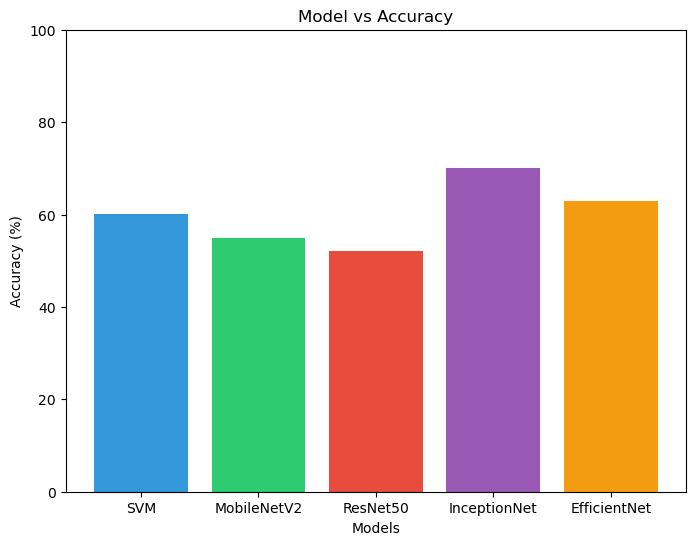

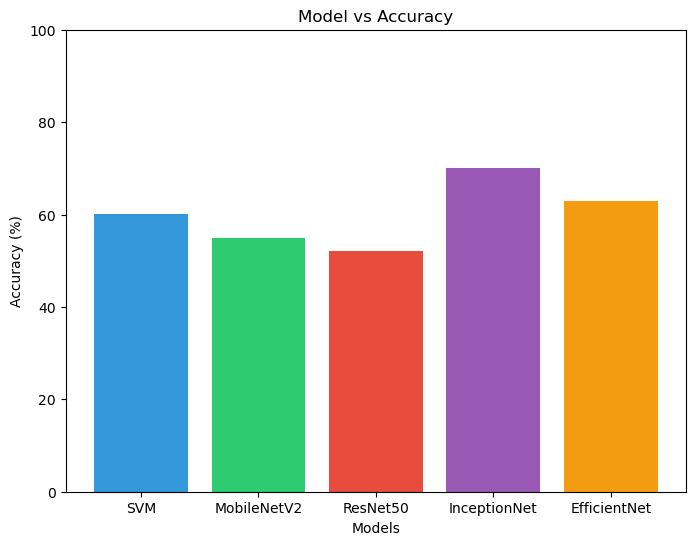

In [3]:
import matplotlib.pyplot as plt

# Model names and corresponding accuracy values
model_names = ['SVM', 'MobileNetV2', 'ResNet50', 'InceptionNet', 'EfficientNet']
accuracies = [svm_accuracy, mobilenetv2_accuracy, resnet50_accuracy, inceptionnet_accuracy, efficientnet_accuracy]

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color=['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12'])
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Model vs Accuracy')
plt.ylim(0, 100)  # Setting the y-axis limit for better visual clarity
plt.show()
import matplotlib.pyplot as plt

# Model names and corresponding accuracy values
model_names = ['SVM', 'MobileNetV2', 'ResNet50', 'InceptionNet', 'EfficientNet']
accuracies = [svm_accuracy, mobilenetv2_accuracy, resnet50_accuracy, inceptionnet_accuracy, efficientnet_accuracy]

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color=['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12'])
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Model vs Accuracy')
plt.ylim(0, 100)  # Setting the y-axis limit for better visual clarity
plt.show()


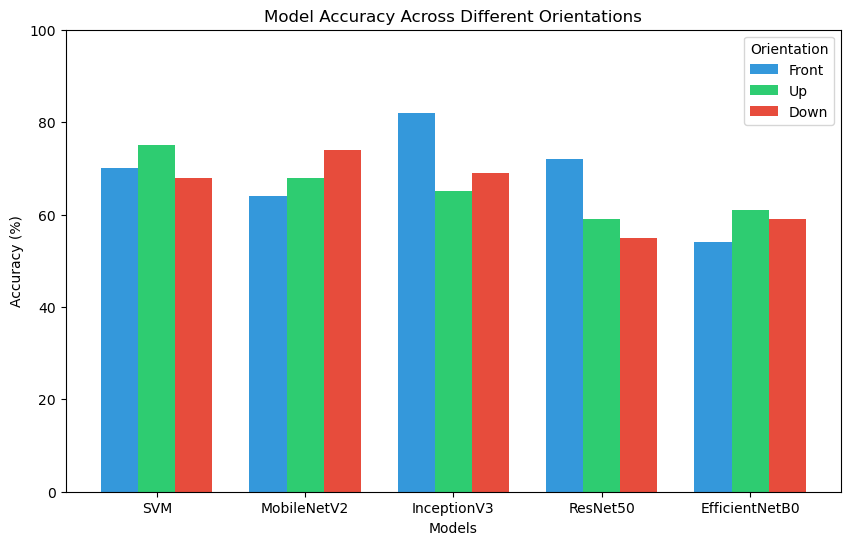

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and accuracy values for each orientation
model_names = ['SVM', 'MobileNetV2', 'InceptionV3', 'ResNet50', 'EfficientNetB0']
accuracy_front = [svm_front, mobilenetv2_front, inceptionv3_front, resnet50_front, efficientnetb0_front]
accuracy_up = [svm_up, mobilenetv2_up, inceptionv3_up, resnet50_up, efficientnetb0_up]
accuracy_down = [svm_down, mobilenetv2_down, inceptionv3_down, resnet50_down, efficientnetb0_down]

# Number of models
x = np.arange(len(model_names))

# Plotting the grouped bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.25  # Width of each bar

# Create bars for each orientation
plt.bar(x - bar_width, accuracy_front, width=bar_width, label='Front', color='#3498db')
plt.bar(x, accuracy_up, width=bar_width, label='Up', color='#2ecc71')
plt.bar(x + bar_width, accuracy_down, width=bar_width, label='Down', color='#e74c3c')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Across Different Orientations')
plt.xticks(x, model_names)
plt.ylim(0, 100)  # Setting y-axis limit for visual clarity
plt.legend(title='Orientation')
plt.show()


In [9]:
# Accuracy results for each model combination and orientation
inceptionv3_svm_front, inceptionv3_svm_up, inceptionv3_svm_down = 83, 61, 61
inceptionv3_rf_front, inceptionv3_rf_up, inceptionv3_rf_down = 65, 57, 53
mobilenetv2_svm_front, mobilenetv2_svm_up, mobilenetv2_svm_down = 69, 49, 58
mobilenetv2_rf_front, mobilenetv2_rf_up, mobilenetv2_rf_down = 58, 70, 47
resnet50_svm_front, resnet50_svm_up, resnet50_svm_down = 56, 63, 43
resnet50_rf_front, resnet50_rf_up, resnet50_rf_down = 66, 57, 62
efficientnetb0_svm_front, efficientnetb0_svm_up, efficientnetb0_svm_down = 52, 54, 71
efficientnetb0_rf_front, efficientnetb0_rf_up, efficientnetb0_rf_down = 67, 60, 57


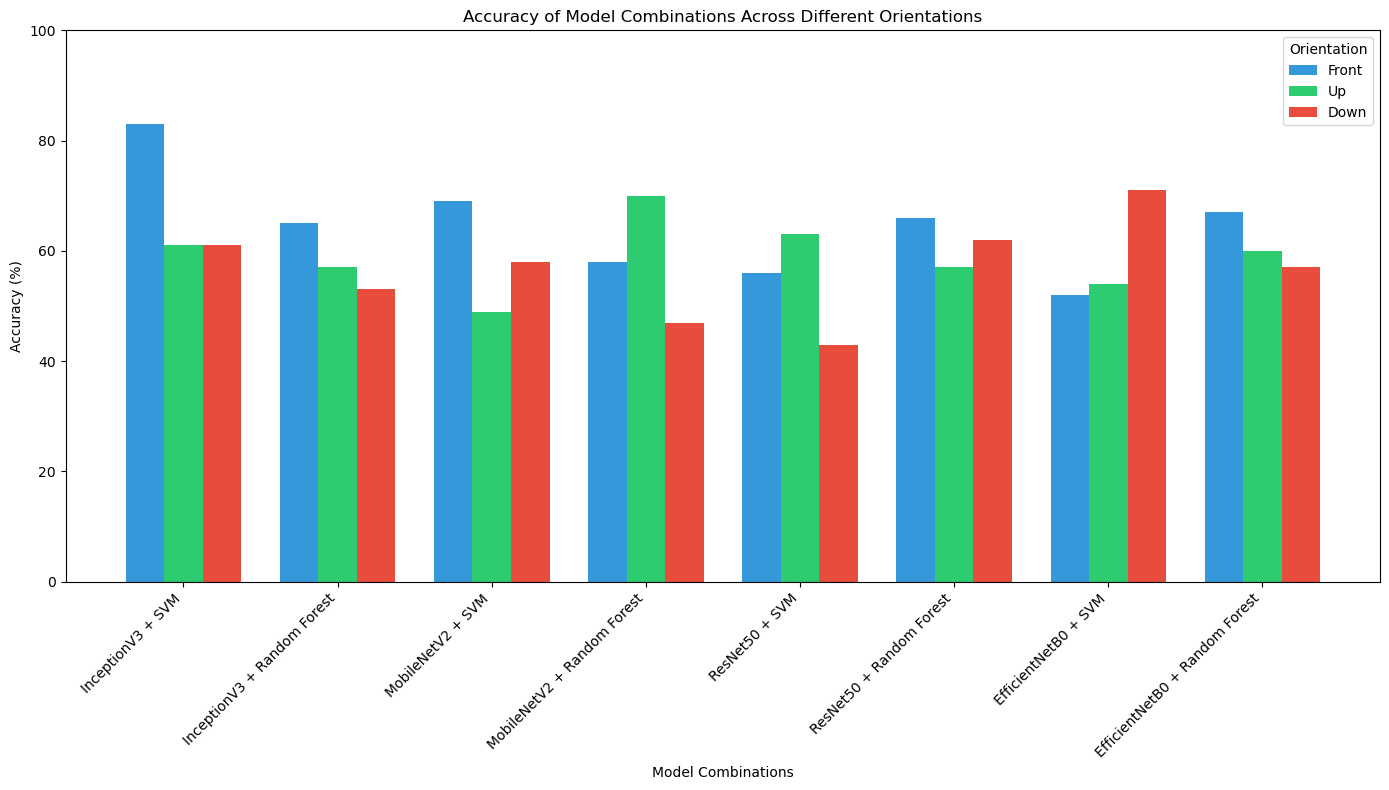

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Model combination names and accuracy values for each orientation
model_combinations = [
    'InceptionV3 + SVM', 'InceptionV3 + Random Forest',
    'MobileNetV2 + SVM', 'MobileNetV2 + Random Forest',
    'ResNet50 + SVM', 'ResNet50 + Random Forest',
    'EfficientNetB0 + SVM', 'EfficientNetB0 + Random Forest'
]
accuracy_front = [
    inceptionv3_svm_front, inceptionv3_rf_front,
    mobilenetv2_svm_front, mobilenetv2_rf_front,
    resnet50_svm_front, resnet50_rf_front,
    efficientnetb0_svm_front, efficientnetb0_rf_front
]
accuracy_up = [
    inceptionv3_svm_up, inceptionv3_rf_up,
    mobilenetv2_svm_up, mobilenetv2_rf_up,
    resnet50_svm_up, resnet50_rf_up,
    efficientnetb0_svm_up, efficientnetb0_rf_up
]
accuracy_down = [
    inceptionv3_svm_down, inceptionv3_rf_down,
    mobilenetv2_svm_down, mobilenetv2_rf_down,
    resnet50_svm_down, resnet50_rf_down,
    efficientnetb0_svm_down, efficientnetb0_rf_down
]

# Number of model combinations
x = np.arange(len(model_combinations))

# Plotting the grouped bar chart
plt.figure(figsize=(14, 8))
bar_width = 0.25  # Width of each bar

# Create bars for each orientation
plt.bar(x - bar_width, accuracy_front, width=bar_width, label='Front', color='#3498db')
plt.bar(x, accuracy_up, width=bar_width, label='Up', color='#2ecc71')
plt.bar(x + bar_width, accuracy_down, width=bar_width, label='Down', color='#e74c3c')

# Adding labels and title
plt.xlabel('Model Combinations')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Model Combinations Across Different Orientations')
plt.xticks(x, model_combinations, rotation=45, ha='right')
plt.ylim(0, 100)  # Setting y-axis limit for visual clarity
plt.legend(title='Orientation')
plt.tight_layout()  # Adjust layout to fit labels and title
plt.show()
